# Salary predict analysis
1. [data prepare](#prepare)
2. [build model](#model)
3. [analysis predict model](#analysis)
4. [reviews](#review)

In [1]:
from copy import deepcopy
import itertools
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm

#import hdbscan
from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
#from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import scale, MinMaxScaler, PolynomialFeatures, label_binarize
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import seaborn as sns
#import scikitplot as skplt
from matplotlib.ticker import NullFormatter

## 1. prepare data <a name="prepare">
### 1.1 explore of related feature

In [67]:

# Read in the survey results, shuffle results
df = pd.read_csv('survey_results_public.csv', low_memory=False)
schema = pd.read_csv('survey_results_schema.csv')

# Columns with relation of salary
RELATED_COLUMN = [
    'OpenSource',
    #'Country',
    'HoursComputer',
    'HoursOutside',
    'SkipMeals',
    'Exercise',
    'FormalEducation',
    'CompanySize',
    'YearsCoding',
    'YearsCodingProf',
    'JobSatisfaction',
    'CareerSatisfaction',
    'DevType',
]

# Columns which must be specified : full-time job
MUST_COLUMN = [
    'Employment'
]
# whole year USD symbol salary
TARGET_COLUMN = [
    'ConvertedSalary'
]


In [69]:
for col in RELATED_COLUMN:
    print(schema[schema.Column == col].values)

[['OpenSource' 'Do you contribute to open source projects?']]
[['HoursComputer'
  'On a typical day, how much time do you spend on a desktop or laptop computer?']]
[['HoursOutside' 'On a typical day, how much time do you spend outside?']]
[['SkipMeals'
  'In a typical week, how many times do you skip a meal in order to be more productive?']]
[['Exercise' 'In a typical week, how many times do you exercise?']]
[['FormalEducation'
  'Which of the following best describes the highest level of formal education that you’ve completed?']]
[['CompanySize'
  'Approximately how many people are employed by the company or organization you work for?']]
[['YearsCoding'
  'Including any education, for how many years have you been coding?']]
[['YearsCodingProf'
  'For how many years have you coded professionally (as a part of your work)?']]
[['JobSatisfaction'
  'How satisfied are you with your current job? If you work more than one job, please answer regarding the one you spend the most hours on.']]
[

### 1.2 preprocessing

multiple options, missing data, categories and so on

In [70]:
# Pick off data science types
all_col = RELATED_COLUMN
all_col.extend(MUST_COLUMN)
all_col.extend(TARGET_COLUMN)
all_col
df = df[all_col]
df[df.Employment == 'Employed part-time']
df.dropna(subset=['ConvertedSalary'], inplace=True)
df.head()

,OpenSource,HoursComputer,HoursOutside,SkipMeals,Exercise,FormalEducation,CompanySize,YearsCoding,YearsCodingProf,JobSatisfaction,CareerSatisfaction,DevType,Employment,ConvertedSalary
1,Yes,5 - 8 hours,30 - 59 minutes,Never,Daily or almost every day,"Bachelor’s degree (BA, BS, B.Eng., etc.)","10,000 or more employees",30 or more years,18-20 years,Moderately dissatisfied,Neither satisfied nor dissatisfied,Database administrator;DevOps specialist;Full-...,Employed full-time,70841.0
4,No,Over 12 hours,1 - 2 hours,Never,3 - 4 times per week,Some college/university study without earning ...,"10,000 or more employees",6-8 years,0-2 years,Slightly satisfied,Moderately satisfied,Data or business analyst;Desktop or enterprise...,Employed full-time,21426.0
5,No,9 - 12 hours,30 - 59 minutes,1 - 2 times per week,1 - 2 times per week,"Bachelor’s degree (BA, BS, B.Eng., etc.)",10 to 19 employees,6-8 years,3-5 years,Moderately satisfied,Slightly satisfied,Back-end developer;Database administrator;Fron...,Employed full-time,41671.0
6,Yes,Over 12 hours,Less than 30 minutes,1 - 2 times per week,I don't typically exercise,Some college/university study without earning ...,"10,000 or more employees",9-11 years,0-2 years,Slightly satisfied,Moderately satisfied,Back-end developer;Front-end developer;Full-st...,Employed full-time,120000.0
8,Yes,9 - 12 hours,Less than 30 minutes,1 - 2 times per week,I don't typically exercise,Some college/university study without earning ...,100 to 499 employees,30 or more years,21-23 years,Moderately satisfied,Moderately satisfied,"Back-end developer;C-suite executive (CEO, CTO...",Employed full-time,250000.0


Bachelor’s degree (BA, BS, B.Eng., etc.)                                              22824
Master’s degree (MA, MS, M.Eng., MBA, etc.)                                           11179
Some college/university study without earning a degree                                 6103
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     3021
Associate degree                                                                       1513
Other doctoral degree (Ph.D, Ed.D., etc.)                                              1191
Professional degree (JD, MD, etc.)                                                      612
Primary/elementary school                                                               388
I never completed any formal education                                                  177
Name: FormalEducation, dtype: int64


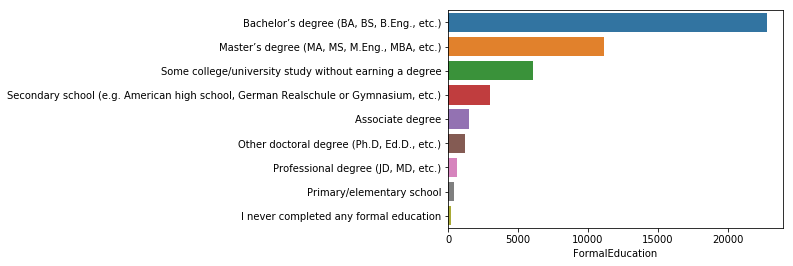

In [71]:
FormalEducation = df['FormalEducation'].value_counts()
print(FormalEducation)
sns.barplot(x = FormalEducation, y = FormalEducation.index)

In [72]:
fe_map={
    'I never completed any formal education':0,
    'Primary/elementary school':1,
    'Some college/university study without earning a degree':2,
    'Associate degree': 3,
    'Bachelor’s degree (BA, BS, B.Eng., etc.)':4,
    'Master’s degree (MA, MS, M.Eng., MBA, etc.)':5,
    'Professional degree (JD, MD, etc.)':6,
    'Other doctoral degree (Ph.D, Ed.D., etc.)':7,
}
df['FormalEducation'] = df['FormalEducation'].map(fe_map)

20 to 99 employees          9775
100 to 499 employees        8141
10,000 or more employees    5756
1,000 to 4,999 employees    4529
10 to 19 employees          4373
Fewer than 10 employees     3952
500 to 999 employees        2668
5,000 to 9,999 employees    1766
Name: CompanySize, dtype: int64


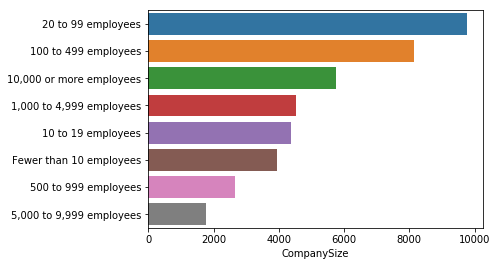

In [73]:
CompanySize = df['CompanySize'].value_counts()
print(CompanySize)
sns.barplot(x = CompanySize, y = CompanySize.index)

In [74]:
cs_map = {
    'Fewer than 10 employees':0,
    '10 to 19 employees':1,
    '20 to 99 employees':2,
    '100 to 499 employees':3,
    '500 to 999 employees':4,
    '1,000 to 4,999 employees':5,
    '5,000 to 9,999 employees':6,
    '10,000 or more employees':7
}
df['CompanySize'] = df['CompanySize'].map(cs_map)

Moderately satisfied                  17213
Extremely satisfied                    8348
Slightly satisfied                     6411
Slightly dissatisfied                  4675
Moderately dissatisfied                4273
Neither satisfied nor dissatisfied     2725
Extremely dissatisfied                 1536
Name: JobSatisfaction, dtype: int64


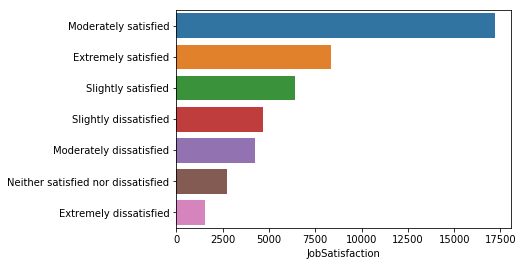

In [75]:
JobSatisfaction = df['JobSatisfaction'].value_counts()
print(JobSatisfaction)
sns.barplot(x = JobSatisfaction, y = JobSatisfaction.index)

In [76]:
js_map = {
    'Extremely dissatisfied':0,
    'Moderately dissatisfied':1,
    'Slightly dissatisfied':2,
    'Neither satisfied nor dissatisfied':3,
    'Slightly satisfied':4,
    'Moderately satisfied':5,
    'Extremely satisfied':6
}
df['JobSatisfaction'] = df['JobSatisfaction'].map(js_map)

9 - 12 hours        25655
5 - 8 hours         13530
Over 12 hours        6075
1 - 4 hours           664
Less than 1 hour       60
Name: HoursComputer, dtype: int64


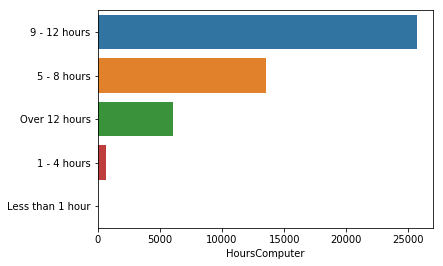

In [77]:

HoursComputer = df['HoursComputer'].value_counts()
print(HoursComputer)
sns.barplot(x = HoursComputer, y = HoursComputer.index)

In [78]:
hc_map = {
    'Less than 1 hour':0,
    '1 - 4 hours':1,
    '5 - 8 hours':2,
    '9 - 12 hours':3,
    'Over 12 hours':4
}
df['HoursComputer'] = df['HoursComputer'].map(hc_map)

1 - 2 hours             17415
30 - 59 minutes         16380
Less than 30 minutes     7715
3 - 4 hours              3754
Over 4 hours              666
Name: HoursOutside, dtype: int64


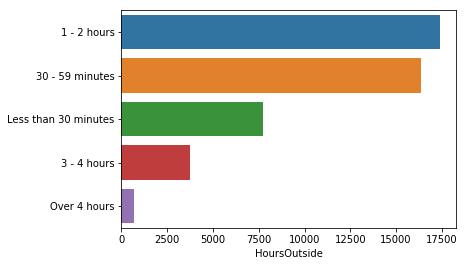

In [79]:
HoursOutside = df['HoursOutside'].value_counts()
print(HoursOutside)
sns.barplot(x = HoursOutside, y = HoursOutside.index)

In [80]:
ho_map = {
    'Less than 30 minutes':0,
    '30 - 59 minutes':1,
    '1 - 2 hours':2,
    '3 - 4 hours':3,
    'Over 4 hours':4,
}
df['HoursOutside'] = df['HoursOutside'].map(ho_map)

In [81]:
print(df['SkipMeals'].value_counts())
sm_map = {
    'Never':0,
    '1 - 2 times per week':1,
    '3 - 4 times per week':2,
    'Daily or almost every day':3
}
df['SkipMeals'] = df['SkipMeals'].map(sm_map)

Never                        30312
1 - 2 times per week         10919
3 - 4 times per week          2454
Daily or almost every day     2240
Name: SkipMeals, dtype: int64


In [82]:
print(df ['Exercise'].value_counts())
exer_map={
    "I don't typically exercise":0,
    '1 - 2 times per week': 1,
    '3 - 4 times per week':2,
    'Daily or almost every day':3
}
df ['Exercise'] = df ['Exercise'].map(exer_map)

I don't typically exercise    17097
1 - 2 times per week          13445
3 - 4 times per week           9465
Daily or almost every day      5998
Name: Exercise, dtype: int64


In [83]:

print(df ['YearsCoding'].value_counts())
yc_map = {
    '0-2 years':0,
    '3-5 years':1,
    '6-8 years':2,
    '9-11 years':3,
    '12-14 years':4,
    '15-17 years':5,
    '18-20 years': 6,
    '21-23 years': 7,
    '24-26 years':8,
    '27-29 years':9,
    '30 or more years':10
}
df ['YearsCoding'] = df ['YearsCoding'].map(yc_map)

6-8 years           10234
3-5 years            9788
9-11 years           7024
12-14 years          4998
15-17 years          3828
0-2 years            3188
18-20 years          3168
30 or more years     2029
21-23 years          1636
24-26 years          1159
27-29 years           631
Name: YearsCoding, dtype: int64


In [84]:
print(df ['CareerSatisfaction'].value_counts())
df['CareerSatisfaction'] = df['CareerSatisfaction'].map(js_map)

Moderately satisfied                  18071
Extremely satisfied                    9221
Slightly satisfied                     8250
Slightly dissatisfied                  3941
Moderately dissatisfied                3109
Neither satisfied nor dissatisfied     3011
Extremely dissatisfied                 1362
Name: CareerSatisfaction, dtype: int64


In [85]:
print(df['YearsCodingProf'].value_counts())
df['YearsCodingProf'] = df['YearsCodingProf'].map(yc_map)

3-5 years           13190
0-2 years           11547
6-8 years            7465
9-11 years           5226
12-14 years          2918
15-17 years          2080
18-20 years          1947
21-23 years           914
30 or more years      774
24-26 years           572
27-29 years           332
Name: YearsCodingProf, dtype: int64


In [86]:
df['OpenSource'] = label_binarize(df['OpenSource'], classes =['Yes', 'No'])
s = df['DevType'].str.split(';')
s_d = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)
for col in s_d.columns:
    df[col] = s_d[col]
df = df.dropna()
X = df.drop(['ConvertedSalary', 'Employment', 'DevType'], axis=1)
y = df['ConvertedSalary']

#X = X.apply(lambda col: col.fillna(col.mode()))
scalary = MinMaxScaler()
scalarx = MinMaxScaler()

y = scalary.fit_transform(y.values.reshape(-1, 1)).reshape(-1)
X = scalarx.fit_transform(X.values)

## 2. Build the model <a name="model">

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)
lm_model = AdaBoostRegressor(n_estimators=250, learning_rate=0.001) # Here you could set any hyperparameters of your model
lm_model.fit(X_train, y_train) # If this model was to predict for new individuals, we probably would want
y_test_preds = lm_model.predict(X_test) #We can then use our fitted model to predict the salary for each
                                        #indvidual in our test set, and see how well these predictions
                                        #match the truth.

print(r2_score(y_test, y_test_preds)) #In this case we are predicting a continuous, numeric response.  Therefore, common
print(mean_squared_error(y_test, y_test_preds)) #metrics to assess fit include Rsquared and MSE.

0.021078990461186775
0.0115207238048078


In [88]:
clf_SVR = SVR()
clf_SVR.fit(X_train, y_train) # If this model was to predict for new individuals, we probably would want
y_test_preds = clf_SVR.predict(X_test) #We can then use our fitted model to predict the salary for each
                                        #indvidual in our test set, and see how well these predictions
                                        #match the truth.

print(r2_score(y_test, y_test_preds)) #In this case we are predicting a continuous, numeric response.  Therefore, common
print(mean_squared_error(y_test, y_test_preds)) #metrics to assess fit include Rsquared and MSE.

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


-0.256461409003774
0.014787040755567924


In [89]:
clf_SVR_l = SVR(kernel='linear')
clf_SVR_l.fit(X_train, y_train) # If this model was to predict for new individuals, we probably would want
y_test_preds = clf_SVR_l.predict(X_test) #We can then use our fitted model to predict the salary for each
                                        #indvidual in our test set, and see how well these predictions
                                        #match the truth.

print(r2_score(y_test, y_test_preds)) #In this case we are predicting a continuous, numeric response.  Therefore, common
print(mean_squared_error(y_test, y_test_preds)) #metrics to assess fit include Rsquared and MSE.

-0.2508749939352819
0.014721295364023581


In [90]:
lm_model = LinearRegression() # Here you could set any hyperparameters of your model
lm_model.fit(X_train, y_train) # If this model was to predict for new individuals, we probably would want
y_test_preds = lm_model.predict(X_test) #We can then use our fitted model to predict the salary for each
                                        #indvidual in our test set, and see how well these predictions
                                        #match the truth.
y_train_preds = lm_model.predict(X_train)
print(r2_score(y_test, y_test_preds)) #In this case we are predicting a continuous, numeric response.  Therefore, common
print(mean_squared_error(y_test, y_test_preds)) #metrics to assess fit include Rsquared and MSE.

0.02761640710169322
0.01144378626768444


## 3. analysis predict model <a name="analysis">

In [92]:
influence = pd.DataFrame(lm_model.coef_, index = df.drop(['ConvertedSalary', 'Employment', 'DevType'], axis=1).columns)

In [98]:
influence.sort_values(0, ascending=False, inplace=True)

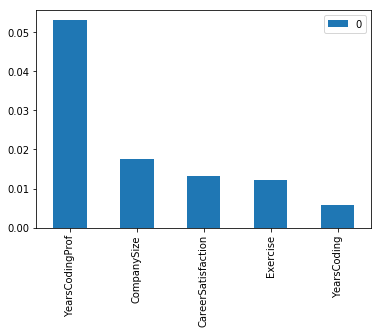

In [99]:
influence.head().plot.bar()

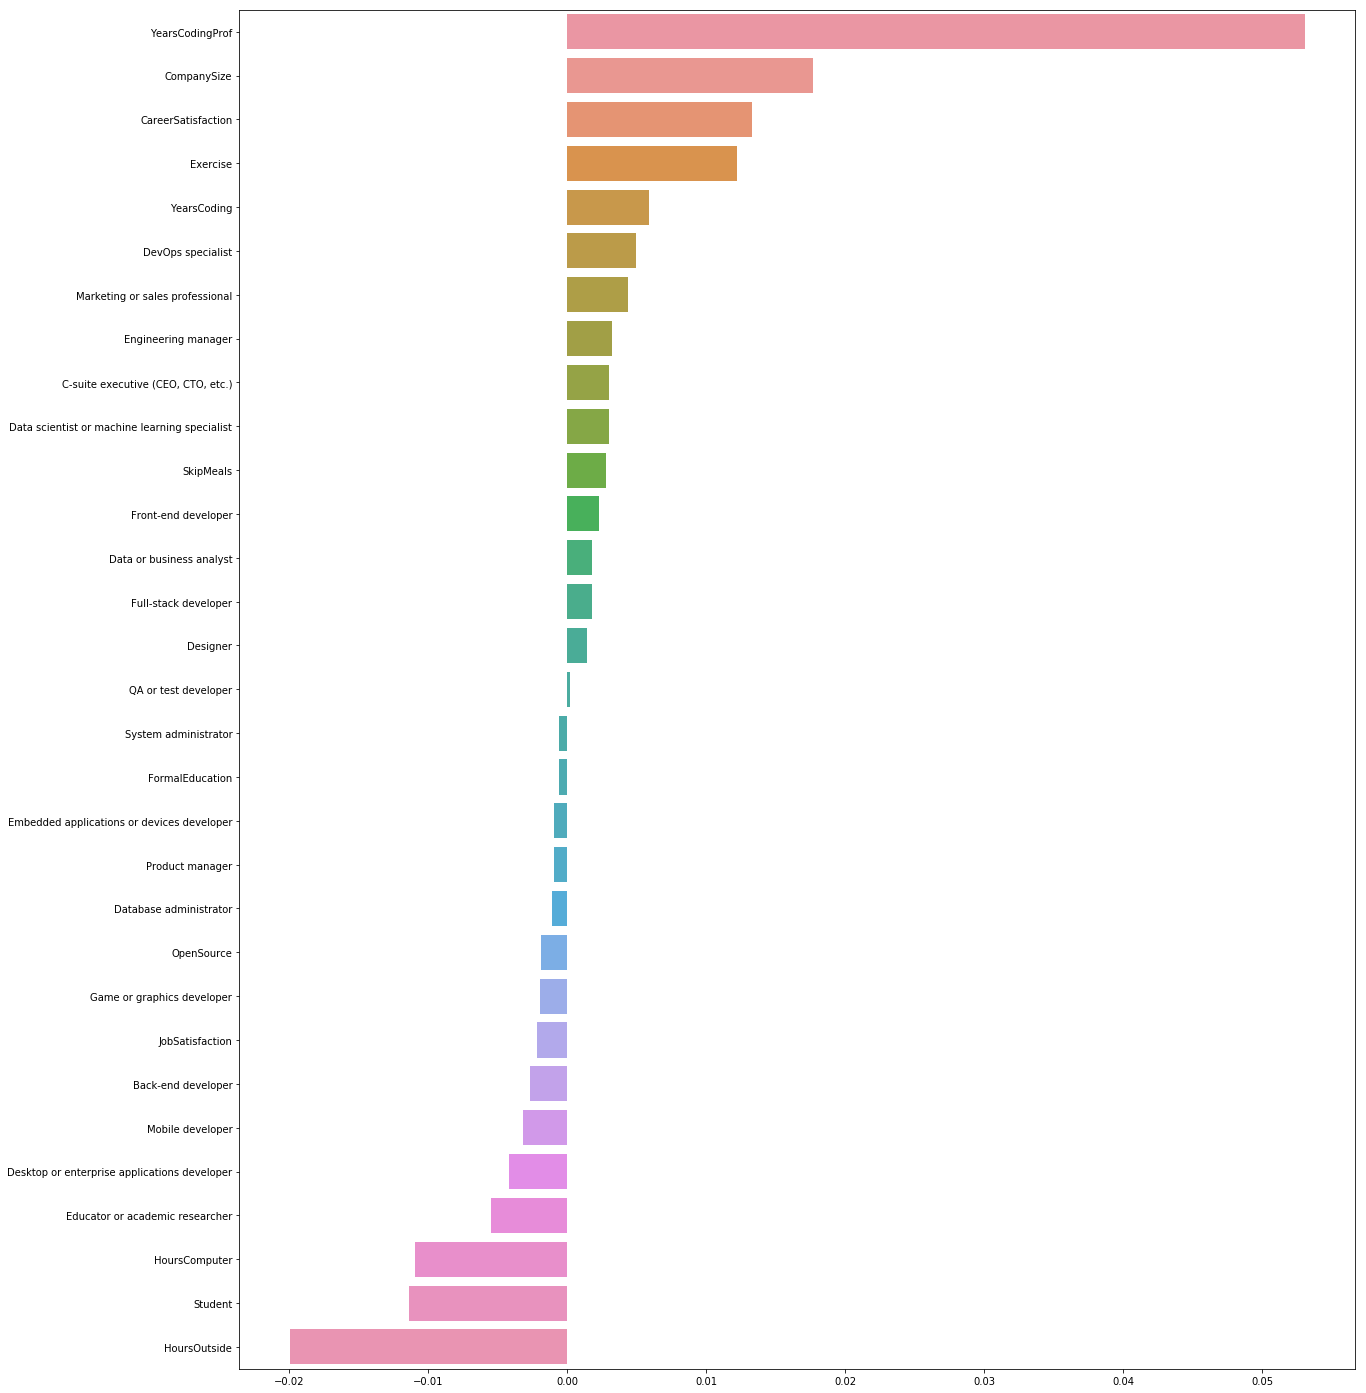

In [100]:
plt.figure(figsize=(20,25))
sns.barplot(influence.values.reshape(-1), influence.index)

## 4. Reviews <a name="review">

Easy ML predict don't make well response. But from result linear regression, We can see some insights:
1. professional coding time is the most important factor
2. company size,position and career satisfacation is big influence. It make sense.
3. opposite，hoursComputer(spend time on a desktop or laptop computer), HoursOutside(spend time outside) make negative influence.
4. conclusion: work-hard is not plus, experience is. different position means large different salary. Job satisfaction not equal to career satisfaction, nor salary and company size.